Created by Joan-Marc Fisa

- Numerai: [FisaGol](https://numer.ai/fisagol)

- Twitter: [@fisagol](https://twitter.com/fisagol)


In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
!pip install numerapi
!pip install vecstack;

  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19880 sha256=3c68ac7711567502bb191b33f893156a18d668da4dbd13b5da1a983c3a14f8b6
  Stored in directory: /root/.cache/pip/wheels/28/fe/0c/fe8e43660e3316d7ce204e59a79a72246c0ae9b6c5c79841c8
Successfully built vecstack


In [3]:
##################################################################
##################### LIBRARIES ##################################
##################################################################

In [4]:
import os
import gc
import csv
import sys
import glob
import time
from pathlib import Path
from multiprocessing import Pool

import numerapi

import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import sklearn
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm, preprocessing, utils
)
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OrdinalEncoder, LabelEncoder,OneHotEncoder
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Activation,LSTM,Bidirectional, MaxPooling2D, Flatten,GRU
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV,cross_val_score,KFold, RepeatedStratifiedKFold,train_test_split
from sklearn.metrics import log_loss, make_scorer, mean_squared_error,classification_report,accuracy_score
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils 
from sklearn import preprocessing
from xgboost import XGBRegressor 
from sklearn.cluster import KMeans
import matplotlib as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import math
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor 

import torch.nn as nn
import torch.nn.functional as F
import torch
from vecstack import stacking

from sklearn import metrics

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred) ** 0.5


In [5]:
def graph_importance(model):
    import xgboost as xgb
    fig, ax = plt.pyplot.subplots(1,1,figsize=(10,10))
    xgb.plot_importance(model, max_num_features=30, ax=ax)

def graph_grafo(model):        
    xgb.to_graphviz(model, num_trees=1)

In [6]:
import keras

In [7]:
def corrcoef(target, pred):
    pred_n = pred - pred.mean()
    target_n = target - target.mean()
    pred_n = pred_n / pred_n.norm()
    target_n = target_n / target_n.norm()
    return (pred_n * target_n).sum()


In [8]:
def spearmanr(target, pred):
    return np.corrcoef(target, pred.rank(pct=True, method="first"))[0, 1]

In [9]:
##############################################################################
########################## DOWLOAD DATA ######################################
##############################################################################

In [10]:
TOURNAMENT_NAME = "nomi"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"

BENCHMARK = 0
BAND = 0.2

In [11]:
seed = 1
rand = np.random.seed(seed)

In [12]:
napi = numerapi.NumerAPI(verbosity="info")

napi.download_current_dataset(unzip=True)

current_ds = napi.get_current_round()
latest_round = os.path.join('numerai_dataset_'+str(current_ds))

2021-08-01 11:14:05,525 INFO numerapi.utils: starting download
./numerai_dataset_275.zip: 415MB [00:09, 45.0MB/s]                           
2021-08-01 11:14:14,759 INFO numerapi.base_api: unzipping file...


In [13]:
##################################################################
##################### LOAD DATA ##################################
##################################################################

In [14]:
%%time
print("# Loading data...")

training_data = pd.read_csv(os.path.join(latest_round, "numerai_training_data.csv")).set_index("id")
tournament_data = pd.read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")
validation_data = tournament_data[tournament_data.data_type == "validation"]

print("# All Loaded...")

# Loading data...
# All Loaded...
CPU times: user 1min 12s, sys: 14.5 s, total: 1min 26s
Wall time: 1min 29s


In [15]:
feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

Loaded 310 features


In [16]:
X = training_data[feature_names]
Y = training_data[training_data.columns[-1]]

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,Y, test_size=0.20,random_state=rand)

In [ ]:
#############################################################################
###########################  CREATING SOME MODELS  ##########################
#############################################################################

In [18]:
pca_test = PCA(n_components=166, random_state=rand)
gc.collect()
pca_test_transform = pca_test.fit_transform(training_data[feature_names])
gc.collect()
training_data_pca = pd.DataFrame(pca_test_transform, columns=[feature_names[0:166]])
gc.collect()

0

In [19]:
pca_tournament = PCA(n_components=166, random_state=rand)
gc.collect()
pca_tournament_transform = pca_tournament.fit_transform(tournament_data[feature_names])
gc.collect()
tournament_data_pca = pd.DataFrame(pca_tournament_transform, columns=[feature_names[0:166]])
gc.collect()

0

In [31]:
X_pca = training_data_pca[training_data_pca.columns[0:166]]
Y_pca = training_data[training_data.columns[-1]]

In [52]:
X_pca_tournament = tournament_data_pca[tournament_data_pca.columns[0:166]]

In [32]:
X_train_pca,X_test_pca,y_train_pca,y_test_pca = train_test_split(X_pca,Y_pca, test_size=0.20,random_state=rand)

In [ ]:
def minmax_norm(df):
    return (df - df.min()) / (df.max() - df.min())

tournament_data[PREDICTION_NAME] = minmax_norm(tournament_data[PREDICTION_NAME])

In [ ]:
# NN MODEL

In [49]:
input_data = tf.keras.Input(shape=(166,))

x = tf.keras.layers.Dense(80, activation='relu')(input_data)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(80, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(80, activation='relu')(x)

output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

optimizer = tf.keras.optimizers.Adam( learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name="Adam")

model = tf.keras.Model(input_data, output)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
gc.collect()

2357

In [50]:
epochs=50
batch_size = 400
gc.collect()

1087

In [ ]:
model.fit(X_train_pca, y_train_pca, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_test_pca, y_test_pca))
gc.collect()

In [55]:
y_preds = model.predict(X_pca_tournament)

In [57]:
tournament_data[PREDICTION_NAME] = y_preds

In [58]:
scores = model.evaluate(X_test_pca, y_test_pca, verbose=1)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

3137/3137 [==============================] - 3s 1ms/step - loss: 0.0514 - mae: 0.1601 - mse: 0.0514

mae: 16.01%


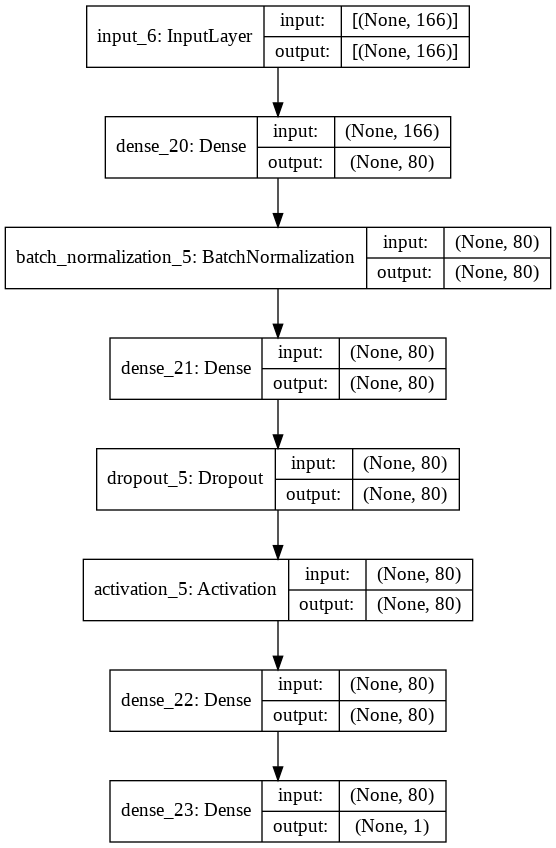

In [59]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [61]:
def neutralize(df, columns, by, proportion=1.0):
  
    scores = df[columns]
    exposures = df[by].values
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))
    gc.collect()
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    gc.collect()
    return scores / scores.std()


In [ ]:
%%time
tournament_data[PREDICTION_NAME] = neutralize(tournament_data, PREDICTION_NAME, feature_names)

In [ ]:
def minmax_norm(df):
    return (df - df.min()) / (df.max() - df.min())

In [ ]:
tournament_data[PREDICTION_NAME] = minmax_norm(tournament_data[PREDICTION_NAME])

In [ ]:
tournament_data[PREDICTION_NAME]

In [ ]:
##############################################################################
######################### MAKE SUBMISSION #################################### 
##############################################################################

In [60]:
tournament_data[PREDICTION_NAME].to_csv('FisaGol_4.csv')

!cp FisaGol_4.csv "drive/My Drive/PHOENIXSIGMA/"